# 3a. Prepare group snapshots from patient snapshots

Collecting patient snapshots together into a group snapshot is useful when predicting a bed count distribution at a point in time. A group snapshot is a subset of patients who were in the ED on a single snapshot date, at a prediction time.

In this notebook, I show how `patientflow` can be used to prepare group snapshots, by dividing patient snapshots into their groups, and storing the group snapshots as dictionary with:
* `snapshot_date` as the key
* `snapshot_ids` of each patient snapshot as the values 

This structure is a convenient way to organise the data when making bed count predictions for different snapshot dates and prediction times, and especially when evaluating those predictions (see next notebook).

## About the examples in this notebook

In this notebook I use fake data that resembles visits to the Emergency Department (ED). The dataset covers mutiple snapshot dates and prediction times.

To start with a very simple example, I apply a series of Bernoulli trials to one group snapshot and visualise the bed count distribution. In that simple example, every patient has the same probability of the outcome.

I then train a model that predicts a probability of admission for each patient. This is a more realistic example, as each patient can have a different probability of admission, based on their data. I apply Bernoulli trials to visualise the predicted distribution of beds needed for those patients. 

I demonstrate functions in `patientflow` that handle the preparation of group snapshots for inference. 

In [21]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate fake snapshots

See [a previous notebook](2a_Create_patient_snapshots.ipynb) for more background on this. 

In [22]:
from patientflow.generate import create_fake_snapshots

prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
snapshots_df=create_fake_snapshots(prediction_times=prediction_times, 
                                   start_date='2023-01-01', 
                                   end_date='2023-04-01',
                                   mean_patients_per_day=100)
snapshots_df.head()


,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
0,2023-01-01,"(6, 0)",270,1,0,47,5.0,1,0,0,0,0
1,2023-01-01,"(6, 0)",3678,12,1,44,2.0,0,1,1,0,0
2,2023-01-01,"(9, 30)",6514,86,0,43,4.0,1,1,0,1,0
3,2023-01-01,"(9, 30)",4956,26,0,53,5.0,1,0,1,0,0
4,2023-01-01,"(9, 30)",3741,9,1,66,4.0,1,0,0,0,0


Note that each record in the snapshots dataframe is indexed by a unique snapshot_id. 

## Prepare group snapshots

`patientflow` includes a `prepare_group_snapshot_dict()` function. As input, it requires a pandas dataframe with a `snapshot_date` column. If a start date and end date are provided, the function will check for any intervening snapshot dates that are missing, and create an empty group snapshot for this date

Here I create a group snapshot dictionary, for patients in the ED at 09.30.


In [23]:
from patientflow.prepare import prepare_group_snapshot_dict

# select the snapshots to include in the probability distribution, 
group_snapshots_dict = prepare_group_snapshot_dict(
    snapshots_df[snapshots_df.prediction_time == (9,30)]
    )

The keys of the dictionary are the `snapshot_date`. The values are a list of patients in the ED at that time, identified by their unique `snapshot_id`.


In [24]:
print("First 10 keys in the snapshots dictionary")
print(list(group_snapshots_dict.keys())[0:10])


First 10 keys in the snapshots dictionary
[datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 3), datetime.date(2023, 1, 4), datetime.date(2023, 1, 5), datetime.date(2023, 1, 6), datetime.date(2023, 1, 7), datetime.date(2023, 1, 8), datetime.date(2023, 1, 9), datetime.date(2023, 1, 10)]


From the first key in the dictionary, we can see the patients belonging to this first snapshot. 

In [25]:
first_group_snapshot_key = list(group_snapshots_dict.keys())[0]
first_group_snapshot_values = group_snapshots_dict[first_group_snapshot_key]

print(f"\nThere are {len(first_group_snapshot_values)} patients in the first group snapshot")

print("\nUnique snapshot_ids in the first group snapshot:")
print(first_group_snapshot_values)

# print("\nPatient snapshots belonging to the first group snapshot:")
# snapshots_df.loc[first_group_snapshot_values]


There are 12 patients in the first group snapshot

Unique snapshot_ids in the first group snapshot:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


We can use the indices to identify the full patient snapshots. 

In [26]:
snapshots_df.loc[first_group_snapshot_values]

,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
2,2023-01-01,"(9, 30)",6514,86,0,43,4.0,1,1,0,1,0
3,2023-01-01,"(9, 30)",4956,26,0,53,5.0,1,0,1,0,0
4,2023-01-01,"(9, 30)",3741,9,1,66,4.0,1,0,0,0,0
5,2023-01-01,"(9, 30)",5287,41,0,60,4.0,1,0,0,0,0
6,2023-01-01,"(9, 30)",872,16,0,59,3.0,1,0,0,0,0
7,2023-01-01,"(9, 30)",2108,20,1,68,3.0,0,0,0,1,0
8,2023-01-01,"(9, 30)",6748,67,0,43,2.0,0,0,1,0,0
9,2023-01-01,"(9, 30)",2282,28,1,73,1.0,0,1,1,0,1
10,2023-01-01,"(9, 30)",2502,50,0,63,3.0,0,0,0,0,0


 More useful is to return not just the indices, but also the data for each visit in the group snapshot. This can be done with the `prepare_patient_snapshots`, which makes the data ready for processing in groups. This will:

 * filter visits to include only those at the requested prediction time
 * randomly select one snapshot per visit, if requested. If `single_snapshot_per_visit` is set to True, a `visit_col` argument must be used, given the name of the column containing visit identifiers
 * return a tuple of (X, y) matrices, ready for inference. The column containing the outcome (ie the label) is specified in the `label_col` argument.  

In [27]:
from patientflow.prepare import prepare_patient_snapshots

first_snapshot_X, first_snapshot_y = prepare_patient_snapshots(
    df=snapshots_df.loc[first_group_snapshot_values], 
    prediction_time=(9,30),
    single_snapshot_per_visit=False,
    label_col="is_admitted"
)
first_snapshot_X

,snapshot_date,prediction_time,patient_id,visit_number,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,
2,2023-01-01,"(9, 30)",6514,86,43,4.0,1,1,0,1,0
3,2023-01-01,"(9, 30)",4956,26,53,5.0,1,0,1,0,0
4,2023-01-01,"(9, 30)",3741,9,66,4.0,1,0,0,0,0
5,2023-01-01,"(9, 30)",5287,41,60,4.0,1,0,0,0,0
6,2023-01-01,"(9, 30)",872,16,59,3.0,1,0,0,0,0
7,2023-01-01,"(9, 30)",2108,20,68,3.0,0,0,0,1,0
8,2023-01-01,"(9, 30)",6748,67,43,2.0,0,0,1,0,0
9,2023-01-01,"(9, 30)",2282,28,73,1.0,0,1,1,0,1
10,2023-01-01,"(9, 30)",2502,50,63,3.0,0,0,0,0,0


## Simple example of making a prediction for a group snapshot

Let's make some predictions for this group. We'll give each of them a probability of being admitted of 0.2. This is equivalent to computing the probable outcome of 12 coin flips, with probability of heads of 0.2.

In [28]:
from scipy import stats
prob_dist_data = stats.binom.pmf(range(13), 12, 0.2)
prob_dist_data


array([6.87194767e-02, 2.06158430e-01, 2.83467842e-01, 2.36223201e-01,
       1.32875551e-01, 5.31502203e-02, 1.55021476e-02, 3.32188877e-03,
       5.19045120e-04, 5.76716800e-05, 4.32537600e-06, 1.96608000e-07,
       4.09600000e-09])

We can plot the predicted distribution using the `prob_dist_plot` function from patientflow.viz

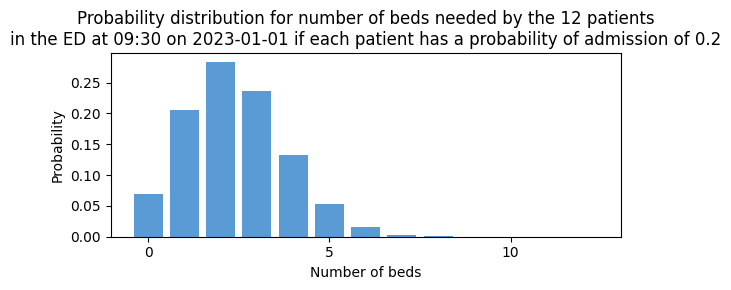

In [29]:
prob_admission_first_group_snapshot = 0.2*len(first_group_snapshot_values)

from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(first_group_snapshot_values)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} if each patient has a probability of admission of 0.2'
)
prob_dist_plot(prob_dist_data, title,  
    include_titles=True)

## Example of making a prediction for a group snapshot with varying probabilities for each patient

In the cell below, I'm using `create_temporal_splits()` to create a training, validation and test set and `train_classifier()` to prepare a XGBoost classifier. This classifier will be used to generate a predicted probability of admission for each patient. See the [2b_Predict_using_patient_snapshots](2b_Predict_using_patient_snapshots.ipynb) notebook for more on the functions shown here.

In [30]:
from datetime import date   
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    snapshots_df,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date, for use when making the splits 
    patient_id="patient_id", # states which column contains the patient id, for use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)
# exclude columns that are not needed for training
exclude_from_training_data=['visit_number', 'snapshot_date', 'prediction_time']

# train the patient-level model
model = train_classifier(
    train_visits,
    valid_visits,
    test_visits,
    grid={"n_estimators": [30]},
    prediction_time=(9, 30),
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings={'latest_triage_score': [1, 2, 3, 4, 5]},
    visit_col='visit_number',
    use_balanced_training=True,
    calibrate_probabilities=True
)



Patient Set Overlaps (before random assignment):
Train-Valid: 0 of 4338
Valid-Test: 75 of 3019
Train-Test: 226 of 5084
All Sets: 0 of 6070 total patients
Split sizes: [3696, 1204, 2502]


Now, using the trained model, I will predict a bed count distribution for one snapshot using `get_prob_dist_for_prediction_moment()`. That function expects the following: 

* `X_test` - the dataset of patient snapshots to be passed to the model
* `y_test` - the vector containing the outcome for each patient snapshot (if these are known)
* `model` - a trained model
* `inference_time` (defaults to True) - if set to False, the function will calculate the observed outcome for the group snapshot; set this to True if the outcomes for each patient as as yet unknown
* `weights` - an optional parameter to weight the probabilities returned by the model. This will be demonstrated in later examples

The function returns a dictionary with two keys:

* `agg_predicted` contains a predicted probability distribution - in this example, for number of admissions among the patients in the snapshot
* `agg_observed` counts the number of times the outcome was observed - in this case number of admissions observed

In [31]:
from patientflow.aggregate import get_prob_dist_for_prediction_moment

bed_count_prob_dist = get_prob_dist_for_prediction_moment(
    first_snapshot_X, 
    model, 
    inference_time=False, 
    y_test=first_snapshot_y
)

bed_count_prob_dist.keys()


dict_keys(['agg_predicted', 'agg_observed'])

Using the `agg_predicted` key, we can plot the probability distribution:


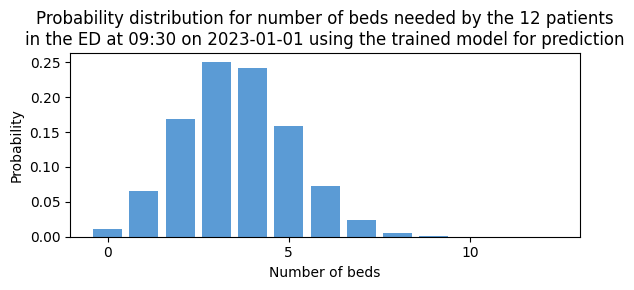

In [32]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(first_snapshot_X)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} using the trained model for prediction'
)
prob_dist_plot(bed_count_prob_dist['agg_predicted'], title,  
    include_titles=True)


The `prob_dist_plot` function will return the figure if requested. For example below, I have added the observed number of admissions for this group snapshot to the figure. 

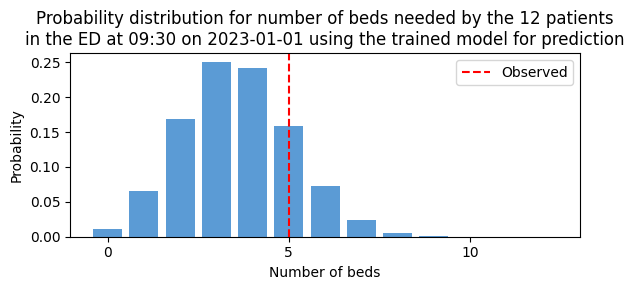

In [33]:
fig = prob_dist_plot(bed_count_prob_dist['agg_predicted'], title,  
    include_titles=True, return_figure=True)
ax = fig.gca()  
ax.axvline(x=bed_count_prob_dist['agg_observed'], color='red', linestyle='--', label='Observed')
ax.legend();


## Make predictions for group snapshots

Now we'll make predictions for the whole test set. 

In [34]:
X_test, y_test = prepare_patient_snapshots(
    df=snapshots_df, 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col='visit_number'
)

The `get_prob_dist` function is set up to receive as input a dictionary of group snapshots, created using the `prepare_group_snapshot_dict` function demonstrated above. It calls `get_prob_dist_for_prediction_moment()` for each entry in the dictionary. The arguments to `get_prob_dist` are: 

* `snapshots_dict` - a snapshots dictionary
* `X_test` - the dataset of patient snapshots to be passed to the model
* `y_test` - the vector containing the outcome for each patient snapshot
* `model` - a trained model
* `weights` - an optional parameter to weight the probabilities returned by the model. This will be demonstrated in later examples

When calling `get_prob_dist_for_prediction_moment` the function will set the `inference_time` parameter to false. 

In [35]:
from patientflow.aggregate import get_prob_dist

group_snapshots_dict = prepare_group_snapshot_dict(
    test_visits[test_visits.prediction_time == (9,30)]
    )
# get probability distribution for this time of day
prob_dists_for_group_snapshots = get_prob_dist(
        group_snapshots_dict, X_test, y_test, model
    )

In the next cell I pick a date from the test set at random, and visualise the predicted distribution. 

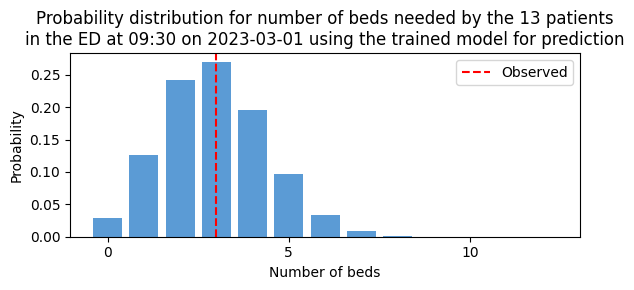

In [36]:
import random
random_snapshot_date = random.choice(list(prob_dists_for_group_snapshots.keys()))
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(prob_dists_for_group_snapshots[random_snapshot_date]["agg_predicted"])} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {random_snapshot_date} using the trained model for prediction'
)
fig = prob_dist_plot(prob_dists_for_group_snapshots[random_snapshot_date]['agg_predicted'], title,  
    include_titles=True, return_figure=True)
ax = fig.gca()  
ax.axvline(x=prob_dists_for_group_snapshots[random_snapshot_date]['agg_observed'], color='red', linestyle='--', label='Observed')
ax.legend();

The returned object is now ready for evaluation, which I cover in the next notebook. 

## Conclusion

In this notebook I have demonstrated the functions in `patientflow` that handle the preparation of group snapshots. These include: 

* `prepare_patient_snapshots`, which makes the data ready for processing in groups.
* `get_prob_dist_for_prediction_moment`, which computes predicted and observed probabilities for a specific snapshot date and prediction time.
* `get_prob_dist` which computes probability distributions for multiple snapshot dates.

I have also shown the use of `prob_dist_plot` to visualise the predicted distribution for one group snapshot.